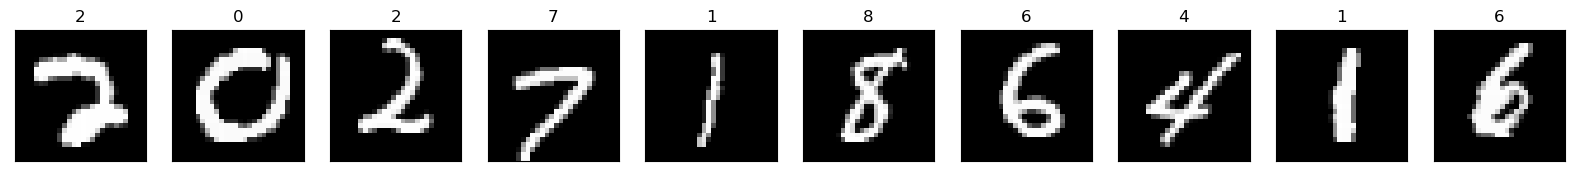

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
   32/60000 [..............................] - ETA: 8:50 - loss: 544.4216

2023-01-17 06:16:56.957365: W tensorflow/c/c_api.cc:291] Operation '{name:'training_4/Adam/dense_6/bias/v/Assign' id:2521 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_6/bias/v, training_4/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


59936/60000 [============================>.] - ETA: 0s - loss: 193.7743

2023-01-17 06:17:11.160634: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_2/mul' id:2122 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/model_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 15s 254us/sample - loss: 193.7553 - val_loss: 174.6142
Epoch 2/10
60000/60000 [==============================] - 14s 238us/sample - loss: 171.7692 - val_loss: 169.7850
Epoch 3/10
60000/60000 [==============================] - 16s 274us/sample - loss: 168.9295 - val_loss: 168.2630
Epoch 4/10
60000/60000 [==============================] - 17s 285us/sample - loss: 167.7814 - val_loss: 167.3188
Epoch 5/10
60000/60000 [==============================] - 17s 275us/sample - loss: 167.0349 - val_loss: 166.6373
Epoch 6/10
60000/60000 [==============================] - 16s 267us/sample - loss: 166.4751 - val_loss: 166.2796
Epoch 7/10
60000/60000 [==============================] - 14s 238us/sample - loss: 166.1041 - val_loss: 165.9347
Epoch 8/10
60000/60000 [==============================] - 15s 250us/sample - loss: 165.7843 - val_loss: 165.6776
Epoch 9/10
60000/60000 [==============================] - 16s 260us/sample - loss: 165.4874 - val_loss: 165

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False, sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()
    
(X_train, y_train), (X_test, y_test) = mnist.load_data()
fig, axes = plt.subplots(ncols=10, sharex=False, sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()



X_train = X_train/255
X_test = X_test/255
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
img_height   = X_train_new.shape[1]    
img_width    = X_train_new.shape[2]    
num_channels = X_train_new.shape[3]    
input_shape =  (img_height, img_width, num_channels)  
latent_dim = 2    



encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

conv_shape = K.int_shape(encoder_conv)

decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)


encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))


vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

history = vae.fit(x=X_train_new, y=X_train_new, epochs=10, batch_size=32, validation_data=(X_test_new,X_test_new))
print("END")

/home/kali/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-17 06:23:29.598291: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_transpose_5/Sigmoid' id:1978 op device:{requested: '', assigned: ''} def:{{{node conv2d_transpose_5/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_transpose_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


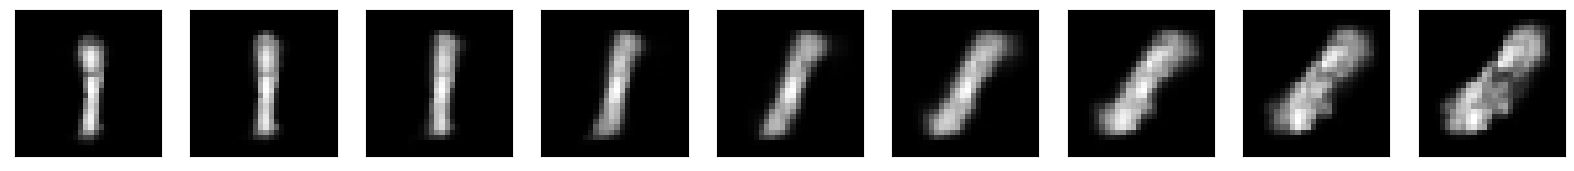

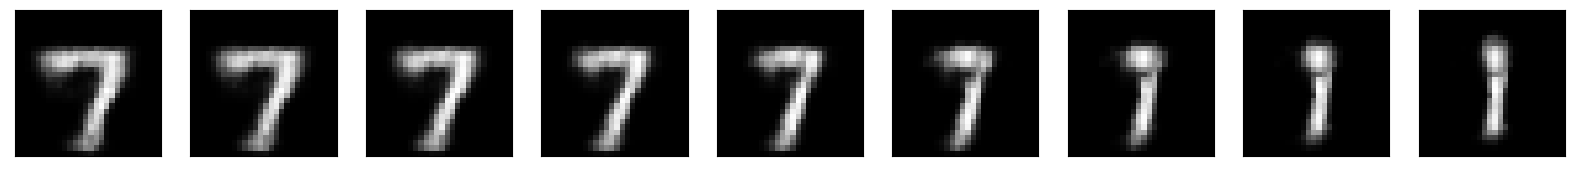

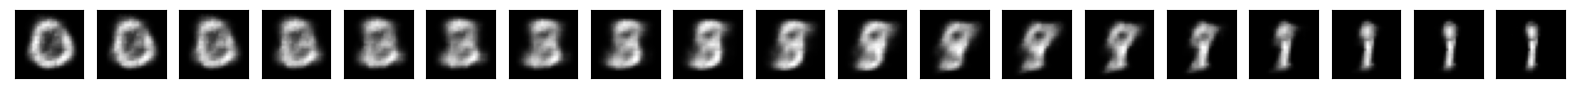

In [5]:
display_image_sequence(0,2,2,0,9)
display_image_sequence(-2,1,0,2,9)
display_image_sequence(0,-2,0,2,19)